In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
np.random.seed(0)

In [3]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [4]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

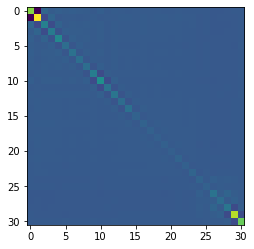

In [5]:
plt.imshow(syscov)

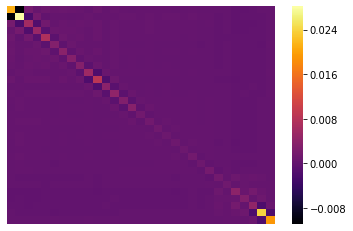

In [6]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("original_cov_binned_JLA.png", dpi=200)

In [7]:
np.min(np.abs(syscov)), np.max(np.abs(syscov)) #checking non-negatives in the diagonal

(1.695011341e-07, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [8]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.001 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 620 matrix 

 Generating 1000 matrix 

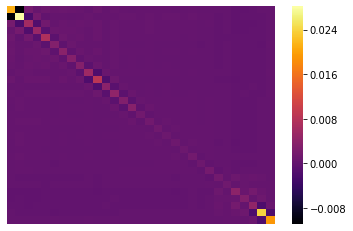

In [9]:
val, vec = np.linalg.eigh(syscov)
D = np.diag(val)
new = (vec+0.1) @ (D) @ (vec+0.1).T
sns.heatmap(pd.DataFrame(syscov), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

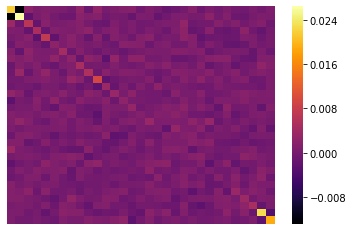

In [10]:
sns.heatmap(pd.DataFrame(covset[10]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [11]:
print(np.shape(covset))

(1000, 31, 31)


(1000, 31, 31)


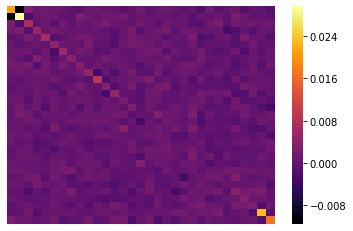

In [12]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [13]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(100, activation='tanh')(input_img)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
dropout_2 (Dropout)          (None, 31)               

In [14]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [15]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=100, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test))
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/500
25/25 [==============================] - 0s 16ms/step - loss: 3.6844e-06 - val_loss: 1.4431e-06
Epoch 2/500
25/25 [==============================] - 0s 4ms/step - loss: 2.0467e-06 - val_loss: 1.3559e-06
Epoch 3/500
25/25 [==============================] - 0s 4ms/step - loss: 1.8762e-06 - val_loss: 1.3131e-06
Epoch 4/500
25/25 [==============================] - 0s 4ms/step - loss: 1.8429e-06 - val_loss: 1.4334e-06
Epoch 5/500
25/25 [==============================] - 0s 4ms/step - loss: 1.8429e-06 - val_loss: 1.3603e-06
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 1.8028e-06 - val_loss: 1.3259e-06
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 1.7595e-06 - val_loss: 1.3084e-06
Epoch 8/500
25/25 [==============================] - 0s 4ms/step - loss: 1.7077e-06 - val_loss: 1.2593e-06
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 1.7116e-06 - val_loss: 1.2686e-06
Epoch 10/500
25/25 [================

Epoch 77/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1404e-06 - val_loss: 1.0793e-06
Epoch 78/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1389e-06 - val_loss: 1.0681e-06
Epoch 79/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1355e-06 - val_loss: 1.0775e-06
Epoch 80/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1392e-06 - val_loss: 1.0739e-06
Epoch 81/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1354e-06 - val_loss: 1.0809e-06
Epoch 82/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1387e-06 - val_loss: 1.0810e-06
Epoch 83/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1394e-06 - val_loss: 1.0772e-06
Epoch 84/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1300e-06 - val_loss: 1.0701e-06
Epoch 85/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1297e-06 - val_loss: 1.0730e-06
Epoch 86/500
25/25 [========

25/25 [==============================] - 0s 4ms/step - loss: 1.1017e-06 - val_loss: 1.0654e-06
Epoch 153/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0989e-06 - val_loss: 1.0741e-06
Epoch 154/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1025e-06 - val_loss: 1.0664e-06
Epoch 155/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0954e-06 - val_loss: 1.0634e-06
Epoch 156/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0980e-06 - val_loss: 1.0804e-06
Epoch 157/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1015e-06 - val_loss: 1.0752e-06
Epoch 158/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0966e-06 - val_loss: 1.0671e-06
Epoch 159/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0979e-06 - val_loss: 1.0707e-06
Epoch 160/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1006e-06 - val_loss: 1.0736e-06
Epoch 161/500
25/25 [============

25/25 [==============================] - 0s 5ms/step - loss: 1.0898e-06 - val_loss: 1.0686e-06
Epoch 228/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0830e-06 - val_loss: 1.0630e-06
Epoch 229/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0807e-06 - val_loss: 1.0713e-06
Epoch 230/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0852e-06 - val_loss: 1.0649e-06
Epoch 231/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0830e-06 - val_loss: 1.0657e-06
Epoch 232/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0854e-06 - val_loss: 1.0655e-06
Epoch 233/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0824e-06 - val_loss: 1.0713e-06
Epoch 234/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0843e-06 - val_loss: 1.0572e-06
Epoch 235/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0811e-06 - val_loss: 1.0633e-06
Epoch 236/500
25/25 [============

25/25 [==============================] - 0s 6ms/step - loss: 1.0785e-06 - val_loss: 1.0582e-06
Epoch 303/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0820e-06 - val_loss: 1.0630e-06
Epoch 304/500
25/25 [==============================] - 0s 7ms/step - loss: 1.0781e-06 - val_loss: 1.0673e-06
Epoch 305/500
25/25 [==============================] - 0s 6ms/step - loss: 1.0802e-06 - val_loss: 1.0647e-06
Epoch 306/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0720e-06 - val_loss: 1.0579e-06
Epoch 307/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0778e-06 - val_loss: 1.0707e-06
Epoch 308/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0762e-06 - val_loss: 1.0621e-06
Epoch 309/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0761e-06 - val_loss: 1.0684e-06
Epoch 310/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0764e-06 - val_loss: 1.0623e-06
Epoch 311/500
25/25 [============

25/25 [==============================] - 0s 5ms/step - loss: 1.0730e-06 - val_loss: 1.0636e-06
Epoch 378/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0735e-06 - val_loss: 1.0599e-06
Epoch 379/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0726e-06 - val_loss: 1.0620e-06
Epoch 380/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0742e-06 - val_loss: 1.0678e-06
Epoch 381/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0745e-06 - val_loss: 1.0717e-06
Epoch 382/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0733e-06 - val_loss: 1.0573e-06
Epoch 383/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0713e-06 - val_loss: 1.0600e-06
Epoch 384/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0734e-06 - val_loss: 1.0686e-06
Epoch 385/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0744e-06 - val_loss: 1.0612e-06
Epoch 386/500
25/25 [============

25/25 [==============================] - 0s 5ms/step - loss: 1.0707e-06 - val_loss: 1.0549e-06
Epoch 453/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0674e-06 - val_loss: 1.0660e-06
Epoch 454/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0736e-06 - val_loss: 1.0626e-06
Epoch 455/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0724e-06 - val_loss: 1.0572e-06
Epoch 456/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0702e-06 - val_loss: 1.0608e-06
Epoch 457/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0719e-06 - val_loss: 1.0599e-06
Epoch 458/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0713e-06 - val_loss: 1.0610e-06
Epoch 459/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0709e-06 - val_loss: 1.0650e-06
Epoch 460/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0737e-06 - val_loss: 1.0685e-06
Epoch 461/500
25/25 [============

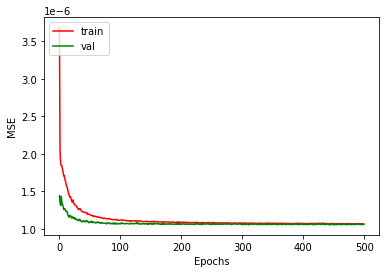

In [16]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLA.png', dpi=200)

In [17]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

1.0548260434006809e-06 1.0641934977684286e-06


In [18]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
# np.min(encoded_imgs)

(200, 31)


(200, 961)


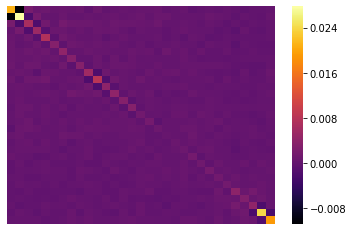

In [19]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")

In [20]:
print(np.shape(decoded_imgs))

(200, 961)


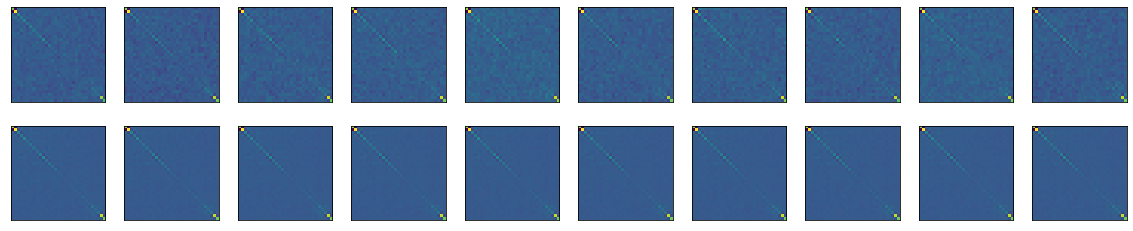

In [21]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

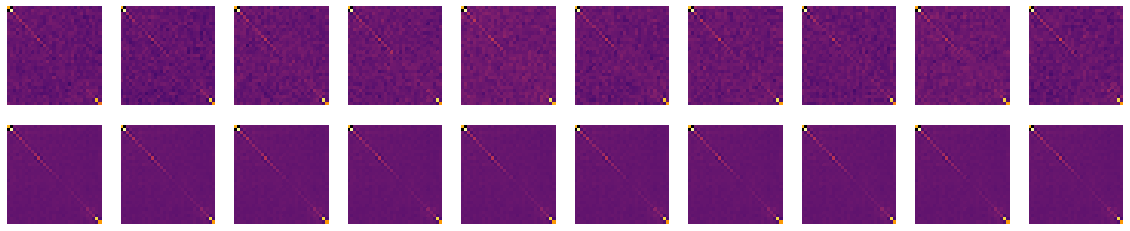

In [22]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

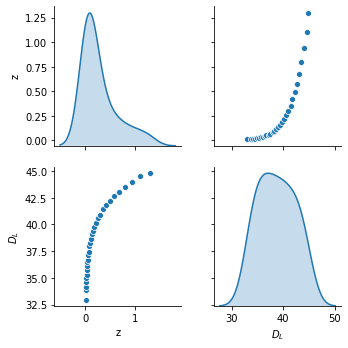

In [23]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
# print(data.head(31))
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistbinnedJLA.png")

In [24]:
shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]

In [25]:
z = data[:,0]
dl = data[:,1:]

In [26]:
# scalerz = StandardScaler()
# # scalerz = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scalerz.fit(z.reshape(-1,1))
# # apply transform
# z = scalerz.transform(z.reshape(-1,1))

In [27]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))
z_train, z_test = np.split(zz, indx)
dl_train, dl_test = np.split(dl, indx)

In [28]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(50, activation='relu')(efirst)
    x = Dense(50, activation='relu')(x)
    x = Dense(30, activation='relu')(x)

    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 31        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
____________________________________________________

In [29]:
model_train = neural_model.fit(z_train, dl_train, batch_size=2,
                                    epochs=300,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/300
12/12 [==============================] - 0s 15ms/step - loss: 1440.8065 - val_loss: 1740.9895
Epoch 2/300
12/12 [==============================] - 0s 4ms/step - loss: 1424.6315 - val_loss: 1724.8381
Epoch 3/300
12/12 [==============================] - 0s 4ms/step - loss: 1397.7687 - val_loss: 1696.4824
Epoch 4/300
12/12 [==============================] - 0s 5ms/step - loss: 1347.5194 - val_loss: 1641.0166
Epoch 5/300
12/12 [==============================] - 0s 4ms/step - loss: 1242.5175 - val_loss: 1513.6290
Epoch 6/300
12/12 [==============================] - 0s 4ms/step - loss: 1033.4910 - val_loss: 1267.7965
Epoch 7/300
12/12 [==============================] - 0s 3ms/step - loss: 688.0616 - val_loss: 870.6124
Epoch 8/300
12/12 [==============================] - 0s 4ms/step - loss: 283.6686 - val_loss: 380.2093
Epoch 9/300
12/12 [==============================] - 0s 4ms/step - loss: 105.8953 - val_loss: 196.7669
Epoch 10/300
12/12 [==============================] - 0s 4ms

12/12 [==============================] - 0s 3ms/step - loss: 0.9882 - val_loss: 0.7002
Epoch 82/300
12/12 [==============================] - 0s 3ms/step - loss: 0.8390 - val_loss: 0.6693
Epoch 83/300
12/12 [==============================] - 0s 4ms/step - loss: 0.8882 - val_loss: 0.6509
Epoch 84/300
12/12 [==============================] - 0s 3ms/step - loss: 0.7805 - val_loss: 0.7427
Epoch 85/300
12/12 [==============================] - 0s 3ms/step - loss: 0.7960 - val_loss: 0.6910
Epoch 86/300
12/12 [==============================] - 0s 4ms/step - loss: 0.8173 - val_loss: 0.6854
Epoch 87/300
12/12 [==============================] - 0s 7ms/step - loss: 0.7876 - val_loss: 0.8809
Epoch 88/300
12/12 [==============================] - 0s 4ms/step - loss: 1.1193 - val_loss: 0.6948
Epoch 89/300
12/12 [==============================] - 0s 3ms/step - loss: 0.9695 - val_loss: 0.6213
Epoch 90/300
12/12 [==============================] - 0s 3ms/step - loss: 0.7790 - val_loss: 0.5952
Epoch 91/300


12/12 [==============================] - 0s 4ms/step - loss: 0.5861 - val_loss: 0.2286
Epoch 163/300
12/12 [==============================] - 0s 4ms/step - loss: 0.5182 - val_loss: 0.3982
Epoch 164/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4225 - val_loss: 0.2478
Epoch 165/300
12/12 [==============================] - 0s 4ms/step - loss: 0.5360 - val_loss: 0.2840
Epoch 166/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4660 - val_loss: 0.2280
Epoch 167/300
12/12 [==============================] - 0s 4ms/step - loss: 0.5076 - val_loss: 0.3040
Epoch 168/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4726 - val_loss: 0.2314
Epoch 169/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4362 - val_loss: 0.2040
Epoch 170/300
12/12 [==============================] - 0s 5ms/step - loss: 0.4948 - val_loss: 0.3512
Epoch 171/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4755 - val_loss: 0.2286
Epoc

12/12 [==============================] - 0s 4ms/step - loss: 0.3559 - val_loss: 0.2048
Epoch 244/300
12/12 [==============================] - 0s 5ms/step - loss: 0.2833 - val_loss: 0.1406
Epoch 245/300
12/12 [==============================] - 0s 4ms/step - loss: 0.2942 - val_loss: 0.0670
Epoch 246/300
12/12 [==============================] - 0s 4ms/step - loss: 0.3031 - val_loss: 0.3035
Epoch 247/300
12/12 [==============================] - 0s 4ms/step - loss: 0.3760 - val_loss: 0.3225
Epoch 248/300
12/12 [==============================] - 0s 3ms/step - loss: 0.4461 - val_loss: 0.0710
Epoch 249/300
12/12 [==============================] - 0s 4ms/step - loss: 0.5820 - val_loss: 0.2093
Epoch 250/300
12/12 [==============================] - 0s 4ms/step - loss: 0.2465 - val_loss: 0.1394
Epoch 251/300
12/12 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.1031
Epoch 252/300
12/12 [==============================] - 0s 3ms/step - loss: 0.2798 - val_loss: 0.0959
Epoc

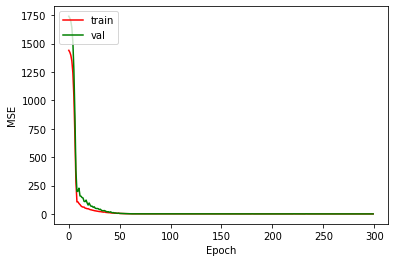

In [30]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_dlbinnedJla.png", dpi=200)

In [31]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet, np.min(model_train.history['loss']), np.min(model_train.history['val_loss'])

(0.1240279767564928, 0.158807173371315, 0.015382939018309116)

In [32]:
# pred = neural_model.predict(z_test)
# pred
np.min(z), np.max(z)

(0.01, 1.3)

In [33]:
# ranz = np.random.uniform(np.min(z), np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z), 31)
ranzz = scalerz.transform(ranz.reshape((-1,1)))

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model.predict(ranzz)
# pred_random

In [34]:
# recover z
# z = scalerz.inverse_transform(z)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [35]:
fake_encoded = np.zeros((1, 31))

In [36]:
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))
print(type(encoded_imgs))


(1, 31)
(31,)
(200, 31)
<class 'numpy.ndarray'>


In [37]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/zz[i]
    fake_encoded[0, i] = alpha * ranzz[i]

In [38]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake), np.shape(fake_encoded)

((1, 961), (1, 31))

9.2860137e-07

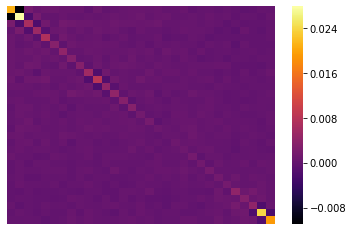

In [40]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

In [208]:
print(np.min(syscov), np.max(syscov), np.mean(syscov)) #checking non-negatives in the diagonal
print(np.min(decoded_fake[0,:]), np.max(decoded_fake[0,:]), np.mean(decoded_fake[0,:])) #checking non-negatives in the diagonal

-0.01084098704 0.02815552265 0.00039265133851975654
-0.010891664 0.02781838 0.00037062063


In [46]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)
# np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu")

In [47]:
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
np.max(errors), np.max(fakeerrors)

(0.1677960745965173, 0.16678843)

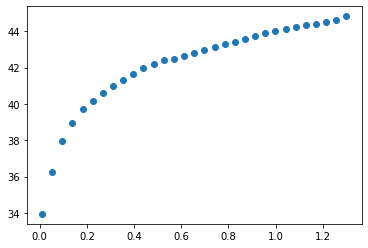

In [48]:
plt.scatter(ranz, pred_random)

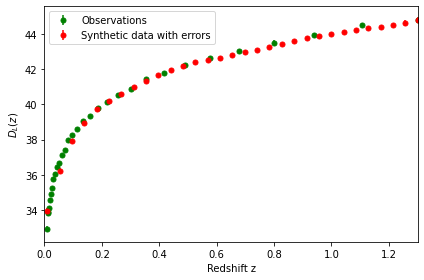

In [49]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
# plt.savefig('fake_vs_binned_jla.png', dpi=200)

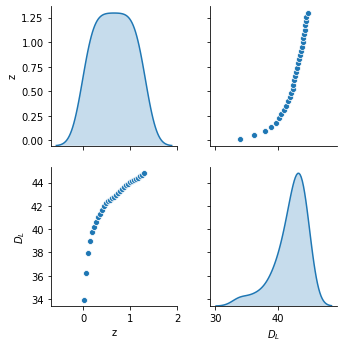

In [50]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
plt.savefig('fake_binned_jla.png')

In [51]:
# Guardar modelos
# autoencoder.save('autoencoderJLA.h5')
# decoder.save('decoderJLA.h5')
# encoder.save('encoderJLA.h5')
# neural_model.save('FFNN_JLA.h5')

# NOW we use dropout as uncertainty estimator

In [178]:
from astroNN.nn.layers import MCDropout

In [179]:
# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img2 = tf.keras.Input(shape=(31*31,))
# begin encoder
x2 = layers.Dense(100, activation='tanh')(input_img2)
x2 = MCDropout(0.1)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
encoded2 = layers.Dense(encoding_dim, activation='tanh')(x2)
x2 = MCDropout(0.1)(encoded2)
#begin decoder
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
decoded2 = layers.Dense(31*31, activation='linear')(x2)


# This model maps an input to its reconstruction
autoencoder2 = tf.keras.Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder2.summary()

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 961)]             0         
_________________________________________________________________
dense_44 (Dense)             (None, 100)               96200     
_________________________________________________________________
MCDropout_28 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)               10100     
_________________________________________________________________
MCDropout_29 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 31)                3131      
_________________________________________________________________
MCDropout_30 (MCDropout)     (None, 31)              

In [180]:
# optimizer = Adam(lr=.005)
# optimizer = Adam(lr=0.0001)


autoencoder2_train = autoencoder2.fit(covset_noise_train, covset_train,
                    epochs=1800,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(covset_noise_test, covset_test))
#                     callbacks=callbacks)

Epoch 1/1800
25/25 [==============================] - 0s 9ms/step - loss: 2.8028e-06 - val_loss: 1.7549e-06
Epoch 2/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.5642e-06 - val_loss: 1.4984e-06
Epoch 3/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.4675e-06 - val_loss: 1.4547e-06
Epoch 4/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.4439e-06 - val_loss: 1.4490e-06
Epoch 5/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.4361e-06 - val_loss: 1.4484e-06
Epoch 6/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.4267e-06 - val_loss: 1.4151e-06
Epoch 7/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.4163e-06 - val_loss: 1.4305e-06
Epoch 8/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.3975e-06 - val_loss: 1.3995e-06
Epoch 9/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.3834e-06 - val_loss: 1.3981e-06
Epoch 10/1800
25/25 [=======

25/25 [==============================] - 0s 4ms/step - loss: 1.1161e-06 - val_loss: 1.1222e-06
Epoch 77/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.1061e-06 - val_loss: 1.1278e-06
Epoch 78/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.1053e-06 - val_loss: 1.1166e-06
Epoch 79/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.1068e-06 - val_loss: 1.1411e-06
Epoch 80/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.1191e-06 - val_loss: 1.1262e-06
Epoch 81/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.1074e-06 - val_loss: 1.1280e-06
Epoch 82/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.1040e-06 - val_loss: 1.1270e-06
Epoch 83/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.1064e-06 - val_loss: 1.1295e-06
Epoch 84/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.1071e-06 - val_loss: 1.1166e-06
Epoch 85/1800
25/25 [============

Epoch 151/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0809e-06 - val_loss: 1.0983e-06
Epoch 152/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0808e-06 - val_loss: 1.0948e-06
Epoch 153/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0843e-06 - val_loss: 1.0931e-06
Epoch 154/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0790e-06 - val_loss: 1.0913e-06
Epoch 155/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0838e-06 - val_loss: 1.0998e-06
Epoch 156/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0820e-06 - val_loss: 1.0910e-06
Epoch 157/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0816e-06 - val_loss: 1.1023e-06
Epoch 158/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0822e-06 - val_loss: 1.0942e-06
Epoch 159/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0804e-06 - val_loss: 1.0937e-06
Epoch 160/

25/25 [==============================] - 0s 4ms/step - loss: 1.0762e-06 - val_loss: 1.0893e-06
Epoch 226/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0715e-06 - val_loss: 1.0912e-06
Epoch 227/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0735e-06 - val_loss: 1.0871e-06
Epoch 228/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0713e-06 - val_loss: 1.0833e-06
Epoch 229/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0715e-06 - val_loss: 1.0818e-06
Epoch 230/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0680e-06 - val_loss: 1.0777e-06
Epoch 231/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0721e-06 - val_loss: 1.0823e-06
Epoch 232/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0733e-06 - val_loss: 1.0860e-06
Epoch 233/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0685e-06 - val_loss: 1.0816e-06
Epoch 234/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0716e-06 - val_loss: 1.0816e-06
Epoch 300/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0666e-06 - val_loss: 1.0833e-06
Epoch 301/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0678e-06 - val_loss: 1.0899e-06
Epoch 302/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0692e-06 - val_loss: 1.0752e-06
Epoch 303/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0678e-06 - val_loss: 1.0793e-06
Epoch 304/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0664e-06 - val_loss: 1.0835e-06
Epoch 305/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0657e-06 - val_loss: 1.0818e-06
Epoch 306/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0712e-06 - val_loss: 1.0877e-06
Epoch 307/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0670e-06 - val_loss: 1.0880e-06
Epoch 308/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0664e-06 - val_loss: 1.0787e-06
Epoch 374/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0651e-06 - val_loss: 1.0827e-06
Epoch 375/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0616e-06 - val_loss: 1.0764e-06
Epoch 376/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0608e-06 - val_loss: 1.0754e-06
Epoch 377/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0633e-06 - val_loss: 1.0742e-06
Epoch 378/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0641e-06 - val_loss: 1.0742e-06
Epoch 379/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0626e-06 - val_loss: 1.0820e-06
Epoch 380/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0639e-06 - val_loss: 1.0790e-06
Epoch 381/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0636e-06 - val_loss: 1.0826e-06
Epoch 382/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0644e-06 - val_loss: 1.0705e-06
Epoch 448/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0615e-06 - val_loss: 1.0762e-06
Epoch 449/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0659e-06 - val_loss: 1.0724e-06
Epoch 450/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0595e-06 - val_loss: 1.0695e-06
Epoch 451/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0606e-06 - val_loss: 1.0764e-06
Epoch 452/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0609e-06 - val_loss: 1.0769e-06
Epoch 453/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0627e-06 - val_loss: 1.0733e-06
Epoch 454/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0626e-06 - val_loss: 1.0770e-06
Epoch 455/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0640e-06 - val_loss: 1.0744e-06
Epoch 456/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0612e-06 - val_loss: 1.0733e-06
Epoch 522/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0607e-06 - val_loss: 1.0748e-06
Epoch 523/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0605e-06 - val_loss: 1.0704e-06
Epoch 524/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0598e-06 - val_loss: 1.0735e-06
Epoch 525/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0585e-06 - val_loss: 1.0730e-06
Epoch 526/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0570e-06 - val_loss: 1.0730e-06
Epoch 527/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0569e-06 - val_loss: 1.0710e-06
Epoch 528/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0602e-06 - val_loss: 1.0706e-06
Epoch 529/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0661e-06 - val_loss: 1.0746e-06
Epoch 530/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0593e-06 - val_loss: 1.0773e-06
Epoch 596/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0570e-06 - val_loss: 1.0710e-06
Epoch 597/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0568e-06 - val_loss: 1.0697e-06
Epoch 598/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0585e-06 - val_loss: 1.0662e-06
Epoch 599/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0573e-06 - val_loss: 1.0681e-06
Epoch 600/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0571e-06 - val_loss: 1.0756e-06
Epoch 601/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0596e-06 - val_loss: 1.0666e-06
Epoch 602/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0584e-06 - val_loss: 1.0717e-06
Epoch 603/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0600e-06 - val_loss: 1.0726e-06
Epoch 604/1800
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0574e-06 - val_loss: 1.0696e-06
Epoch 670/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0572e-06 - val_loss: 1.0706e-06
Epoch 671/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0562e-06 - val_loss: 1.0677e-06
Epoch 672/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0578e-06 - val_loss: 1.0758e-06
Epoch 673/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0598e-06 - val_loss: 1.0704e-06
Epoch 674/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0563e-06 - val_loss: 1.0747e-06
Epoch 675/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0567e-06 - val_loss: 1.0751e-06
Epoch 676/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0569e-06 - val_loss: 1.0657e-06
Epoch 677/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0556e-06 - val_loss: 1.0742e-06
Epoch 678/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0569e-06 - val_loss: 1.0675e-06
Epoch 744/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0565e-06 - val_loss: 1.0688e-06
Epoch 745/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0543e-06 - val_loss: 1.0663e-06
Epoch 746/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0564e-06 - val_loss: 1.0679e-06
Epoch 747/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0583e-06 - val_loss: 1.0682e-06
Epoch 748/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0577e-06 - val_loss: 1.0671e-06
Epoch 749/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0538e-06 - val_loss: 1.0685e-06
Epoch 750/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0580e-06 - val_loss: 1.0791e-06
Epoch 751/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0577e-06 - val_loss: 1.0662e-06
Epoch 752/1800
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0570e-06 - val_loss: 1.0693e-06
Epoch 818/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0587e-06 - val_loss: 1.0704e-06
Epoch 819/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0533e-06 - val_loss: 1.0700e-06
Epoch 820/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0562e-06 - val_loss: 1.0739e-06
Epoch 821/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0566e-06 - val_loss: 1.0706e-06
Epoch 822/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0580e-06 - val_loss: 1.0661e-06
Epoch 823/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0562e-06 - val_loss: 1.0654e-06
Epoch 824/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0524e-06 - val_loss: 1.0706e-06
Epoch 825/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0573e-06 - val_loss: 1.0723e-06
Epoch 826/1800
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0559e-06 - val_loss: 1.0729e-06
Epoch 892/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0580e-06 - val_loss: 1.0689e-06
Epoch 893/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0571e-06 - val_loss: 1.0638e-06
Epoch 894/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0546e-06 - val_loss: 1.0689e-06
Epoch 895/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0552e-06 - val_loss: 1.0668e-06
Epoch 896/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0539e-06 - val_loss: 1.0698e-06
Epoch 897/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0547e-06 - val_loss: 1.0734e-06
Epoch 898/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0565e-06 - val_loss: 1.0762e-06
Epoch 899/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0550e-06 - val_loss: 1.0632e-06
Epoch 900/1800
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0531e-06 - val_loss: 1.0668e-06
Epoch 966/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0562e-06 - val_loss: 1.0722e-06
Epoch 967/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0545e-06 - val_loss: 1.0652e-06
Epoch 968/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0517e-06 - val_loss: 1.0657e-06
Epoch 969/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0535e-06 - val_loss: 1.0739e-06
Epoch 970/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0575e-06 - val_loss: 1.0760e-06
Epoch 971/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0528e-06 - val_loss: 1.0659e-06
Epoch 972/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0564e-06 - val_loss: 1.0738e-06
Epoch 973/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0579e-06 - val_loss: 1.0734e-06
Epoch 974/1800
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0544e-06 - val_loss: 1.0688e-06
Epoch 1040/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0540e-06 - val_loss: 1.0724e-06
Epoch 1041/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0538e-06 - val_loss: 1.0713e-06
Epoch 1042/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0541e-06 - val_loss: 1.0716e-06
Epoch 1043/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0542e-06 - val_loss: 1.0673e-06
Epoch 1044/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0508e-06 - val_loss: 1.0641e-06
Epoch 1045/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0497e-06 - val_loss: 1.0653e-06
Epoch 1046/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0523e-06 - val_loss: 1.0655e-06
Epoch 1047/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0530e-06 - val_loss: 1.0702e-06
Epoch 1048/1800
2

Epoch 1113/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0527e-06 - val_loss: 1.0683e-06
Epoch 1114/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0522e-06 - val_loss: 1.0692e-06
Epoch 1115/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0516e-06 - val_loss: 1.0676e-06
Epoch 1116/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0512e-06 - val_loss: 1.0673e-06
Epoch 1117/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0535e-06 - val_loss: 1.0692e-06
Epoch 1118/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0506e-06 - val_loss: 1.0739e-06
Epoch 1119/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0519e-06 - val_loss: 1.0683e-06
Epoch 1120/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0532e-06 - val_loss: 1.0693e-06
Epoch 1121/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0531e-06 - val_loss: 1.0727e-06
E

Epoch 1187/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0476e-06 - val_loss: 1.0635e-06
Epoch 1188/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0505e-06 - val_loss: 1.0658e-06
Epoch 1189/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0537e-06 - val_loss: 1.0691e-06
Epoch 1190/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0538e-06 - val_loss: 1.0670e-06
Epoch 1191/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0533e-06 - val_loss: 1.0683e-06
Epoch 1192/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0518e-06 - val_loss: 1.0664e-06
Epoch 1193/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0518e-06 - val_loss: 1.0666e-06
Epoch 1194/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0506e-06 - val_loss: 1.0609e-06
Epoch 1195/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0486e-06 - val_loss: 1.0620e-06
E

Epoch 1261/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0526e-06 - val_loss: 1.0709e-06
Epoch 1262/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0503e-06 - val_loss: 1.0619e-06
Epoch 1263/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0505e-06 - val_loss: 1.0660e-06
Epoch 1264/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0495e-06 - val_loss: 1.0658e-06
Epoch 1265/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0489e-06 - val_loss: 1.0630e-06
Epoch 1266/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0492e-06 - val_loss: 1.0690e-06
Epoch 1267/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0496e-06 - val_loss: 1.0689e-06
Epoch 1268/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0485e-06 - val_loss: 1.0677e-06
Epoch 1269/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0519e-06 - val_loss: 1.0662e-06
E

Epoch 1335/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0475e-06 - val_loss: 1.0670e-06
Epoch 1336/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0495e-06 - val_loss: 1.0622e-06
Epoch 1337/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0509e-06 - val_loss: 1.0721e-06
Epoch 1338/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0496e-06 - val_loss: 1.0627e-06
Epoch 1339/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0460e-06 - val_loss: 1.0632e-06
Epoch 1340/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0490e-06 - val_loss: 1.0754e-06
Epoch 1341/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0541e-06 - val_loss: 1.0743e-06
Epoch 1342/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0500e-06 - val_loss: 1.0681e-06
Epoch 1343/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0465e-06 - val_loss: 1.0702e-06
E

Epoch 1409/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0489e-06 - val_loss: 1.0646e-06
Epoch 1410/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0478e-06 - val_loss: 1.0653e-06
Epoch 1411/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0500e-06 - val_loss: 1.0658e-06
Epoch 1412/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0538e-06 - val_loss: 1.0696e-06
Epoch 1413/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0484e-06 - val_loss: 1.0661e-06
Epoch 1414/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0478e-06 - val_loss: 1.0647e-06
Epoch 1415/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0504e-06 - val_loss: 1.0593e-06
Epoch 1416/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0474e-06 - val_loss: 1.0636e-06
Epoch 1417/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0487e-06 - val_loss: 1.0698e-06
E

Epoch 1483/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0476e-06 - val_loss: 1.0622e-06
Epoch 1484/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0496e-06 - val_loss: 1.0614e-06
Epoch 1485/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0478e-06 - val_loss: 1.0645e-06
Epoch 1486/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0495e-06 - val_loss: 1.0672e-06
Epoch 1487/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0473e-06 - val_loss: 1.0656e-06
Epoch 1488/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0451e-06 - val_loss: 1.0638e-06
Epoch 1489/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0462e-06 - val_loss: 1.0670e-06
Epoch 1490/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0460e-06 - val_loss: 1.0642e-06
Epoch 1491/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0488e-06 - val_loss: 1.0670e-06
E

Epoch 1557/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0472e-06 - val_loss: 1.0637e-06
Epoch 1558/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0467e-06 - val_loss: 1.0590e-06
Epoch 1559/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0452e-06 - val_loss: 1.0592e-06
Epoch 1560/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0451e-06 - val_loss: 1.0682e-06
Epoch 1561/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0442e-06 - val_loss: 1.0657e-06
Epoch 1562/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0471e-06 - val_loss: 1.0604e-06
Epoch 1563/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0452e-06 - val_loss: 1.0677e-06
Epoch 1564/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0501e-06 - val_loss: 1.0634e-06
Epoch 1565/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0473e-06 - val_loss: 1.0631e-06
E

Epoch 1631/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0450e-06 - val_loss: 1.0630e-06
Epoch 1632/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0447e-06 - val_loss: 1.0678e-06
Epoch 1633/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0473e-06 - val_loss: 1.0674e-06
Epoch 1634/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0478e-06 - val_loss: 1.0705e-06
Epoch 1635/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0436e-06 - val_loss: 1.0636e-06
Epoch 1636/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0442e-06 - val_loss: 1.0701e-06
Epoch 1637/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0470e-06 - val_loss: 1.0652e-06
Epoch 1638/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0452e-06 - val_loss: 1.0603e-06
Epoch 1639/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0448e-06 - val_loss: 1.0665e-06
E

Epoch 1705/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0412e-06 - val_loss: 1.0607e-06
Epoch 1706/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0441e-06 - val_loss: 1.0656e-06
Epoch 1707/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0487e-06 - val_loss: 1.0710e-06
Epoch 1708/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0444e-06 - val_loss: 1.0569e-06
Epoch 1709/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0424e-06 - val_loss: 1.0666e-06
Epoch 1710/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0440e-06 - val_loss: 1.0738e-06
Epoch 1711/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0446e-06 - val_loss: 1.0743e-06
Epoch 1712/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0472e-06 - val_loss: 1.0709e-06
Epoch 1713/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0485e-06 - val_loss: 1.0685e-06
E

Epoch 1779/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0407e-06 - val_loss: 1.0690e-06
Epoch 1780/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0445e-06 - val_loss: 1.0609e-06
Epoch 1781/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0408e-06 - val_loss: 1.0624e-06
Epoch 1782/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0462e-06 - val_loss: 1.0621e-06
Epoch 1783/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0415e-06 - val_loss: 1.0663e-06
Epoch 1784/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0417e-06 - val_loss: 1.0656e-06
Epoch 1785/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0403e-06 - val_loss: 1.0677e-06
Epoch 1786/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0427e-06 - val_loss: 1.0654e-06
Epoch 1787/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0414e-06 - val_loss: 1.0624e-06
E

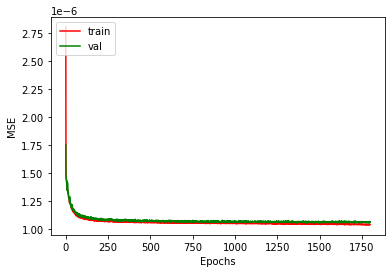

In [181]:
plt.plot(autoencoder2_train.history['loss'], color='r', )
plt.plot(autoencoder2_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLAdropout.png', dpi=200)

In [182]:
encoder2 = tf.keras.Model(input_img2, encoded2)
# This is our encoded (32-dimensional) input
encoded2_input = tf.keras.Input(shape=(encoding_dim,))

decoder2_layer1 = autoencoder2.layers[-5]
decoder2_layer2 = autoencoder2.layers[-4]
decoder2_layer3 = autoencoder2.layers[-3]
decoder2_layer4 = autoencoder2.layers[-2]
decoder2_layer5 = autoencoder2.layers[-1]

# create the decoder model
decoder2 = Model(encoded2_input, 
                decoder2_layer5(decoder2_layer4(decoder2_layer3(decoder2_layer2(decoder2_layer1(encoded2_input))))))

In [183]:
decoder2.summary()

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 31)]              0         
_________________________________________________________________
dense_47 (Dense)             (None, 100)               3200      
_________________________________________________________________
MCDropout_31 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               10100     
_________________________________________________________________
MCDropout_32 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 961)               97061     
Total params: 110,361
Trainable params: 110,361
Non-trainable params: 0
_______________________________________________

In [184]:
# Generate test data
test_batch_size = 31*31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0, 2., test_batch_size)
print(np.shape(fake_encoded))
mc_dropout_num = 100  # Run Dropout 100 times
predictions_dec = np.zeros((mc_dropout_num, 1, test_batch_size))
uncertainty = np.zeros((mc_dropout_num, 1, test_batch_size))
for i in range(mc_dropout_num):
    predictions_dec[i] = decoder2.predict(fake_encoded)
    
# get mean results and its varience
prediction_mc_dropout_dec = np.mean(predictions_dec, axis=0, dtype=np.float64)
std_mc_dropout_dec = np.std(predictions_dec, axis=0, dtype=np.float64)
np.shape(prediction_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(1, 31)


((1, 961), (1, 961))

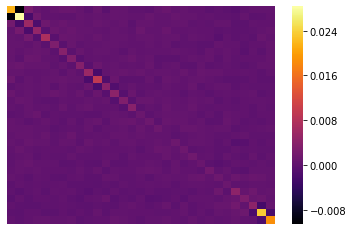

In [185]:
sns.heatmap(pd.DataFrame(prediction_mc_dropout_dec[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [186]:
np.mean(std_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(7.333522670896813e-05, (1, 961))

In [187]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.1)(efirst)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.1)(x)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.1)(x)
    x = Dense(30, activation='relu')(x)
    x = MCDropout(0.1)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_50 (Dense)             (None, 50)                100       
_________________________________________________________________
MCDropout_33 (MCDropout)     (None, 50)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 50)                2550      
_________________________________________________________________
MCDropout_34 (MCDropout)     (None, 50)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 50)                2550      
_________________________________________________________________
MCDropout_35 (MCDropout)     (None, 50)              

In [188]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=2,
                                    epochs=800,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/800
12/12 [==============================] - 0s 13ms/step - loss: 1438.6475 - val_loss: 1733.4041
Epoch 2/800
12/12 [==============================] - 0s 2ms/step - loss: 1421.9225 - val_loss: 1708.7333
Epoch 3/800
12/12 [==============================] - 0s 3ms/step - loss: 1392.9108 - val_loss: 1664.7560
Epoch 4/800
12/12 [==============================] - 0s 3ms/step - loss: 1335.7518 - val_loss: 1598.6620
Epoch 5/800
12/12 [==============================] - 0s 3ms/step - loss: 1249.0908 - val_loss: 1477.7000
Epoch 6/800
12/12 [==============================] - 0s 3ms/step - loss: 1040.9136 - val_loss: 1194.8998
Epoch 7/800
12/12 [==============================] - 0s 3ms/step - loss: 668.9839 - val_loss: 689.3748
Epoch 8/800
12/12 [==============================] - 0s 3ms/step - loss: 244.9382 - val_loss: 208.9419
Epoch 9/800
12/12 [==============================] - 0s 3ms/step - loss: 157.2526 - val_loss: 82.3322
Epoch 10/800
12/12 [==============================] - 0s 3ms/

Epoch 81/800
12/12 [==============================] - 0s 2ms/step - loss: 41.7907 - val_loss: 27.0095
Epoch 82/800
12/12 [==============================] - 0s 2ms/step - loss: 22.4991 - val_loss: 22.5379
Epoch 83/800
12/12 [==============================] - 0s 2ms/step - loss: 18.9151 - val_loss: 83.1384
Epoch 84/800
12/12 [==============================] - 0s 3ms/step - loss: 29.8967 - val_loss: 17.5340
Epoch 85/800
12/12 [==============================] - 0s 3ms/step - loss: 32.1413 - val_loss: 33.4255
Epoch 86/800
12/12 [==============================] - 0s 3ms/step - loss: 61.5345 - val_loss: 68.5259
Epoch 87/800
12/12 [==============================] - 0s 2ms/step - loss: 39.2275 - val_loss: 62.9172
Epoch 88/800
12/12 [==============================] - 0s 3ms/step - loss: 26.4394 - val_loss: 47.6994
Epoch 89/800
12/12 [==============================] - 0s 3ms/step - loss: 31.0997 - val_loss: 13.8787
Epoch 90/800
12/12 [==============================] - 0s 3ms/step - loss: 37.1396 

12/12 [==============================] - 0s 3ms/step - loss: 26.5333 - val_loss: 45.2984
Epoch 161/800
12/12 [==============================] - 0s 3ms/step - loss: 27.1190 - val_loss: 51.6576
Epoch 162/800
12/12 [==============================] - 0s 3ms/step - loss: 17.4269 - val_loss: 21.7154
Epoch 163/800
12/12 [==============================] - 0s 3ms/step - loss: 25.7157 - val_loss: 23.6134
Epoch 164/800
12/12 [==============================] - 0s 3ms/step - loss: 19.7744 - val_loss: 61.1064
Epoch 165/800
12/12 [==============================] - 0s 3ms/step - loss: 22.8522 - val_loss: 45.0559
Epoch 166/800
12/12 [==============================] - 0s 3ms/step - loss: 39.4770 - val_loss: 6.9174
Epoch 167/800
12/12 [==============================] - 0s 4ms/step - loss: 22.5684 - val_loss: 26.5522
Epoch 168/800
12/12 [==============================] - 0s 3ms/step - loss: 13.6853 - val_loss: 33.8761
Epoch 169/800
12/12 [==============================] - 0s 3ms/step - loss: 18.2029 - val

12/12 [==============================] - 0s 3ms/step - loss: 13.9235 - val_loss: 13.5491
Epoch 240/800
12/12 [==============================] - 0s 3ms/step - loss: 16.9281 - val_loss: 42.8625
Epoch 241/800
12/12 [==============================] - 0s 3ms/step - loss: 21.9219 - val_loss: 11.1574
Epoch 242/800
12/12 [==============================] - 0s 3ms/step - loss: 20.6284 - val_loss: 29.8904
Epoch 243/800
12/12 [==============================] - 0s 3ms/step - loss: 22.3626 - val_loss: 18.0756
Epoch 244/800
12/12 [==============================] - 0s 3ms/step - loss: 33.3050 - val_loss: 55.3089
Epoch 245/800
12/12 [==============================] - 0s 3ms/step - loss: 33.9542 - val_loss: 26.6934
Epoch 246/800
12/12 [==============================] - 0s 3ms/step - loss: 32.0798 - val_loss: 37.3388
Epoch 247/800
12/12 [==============================] - 0s 3ms/step - loss: 17.5143 - val_loss: 23.0297
Epoch 248/800
12/12 [==============================] - 0s 3ms/step - loss: 31.3224 - va

12/12 [==============================] - 0s 3ms/step - loss: 21.4359 - val_loss: 29.0958
Epoch 319/800
12/12 [==============================] - 0s 3ms/step - loss: 21.4988 - val_loss: 21.9017
Epoch 320/800
12/12 [==============================] - 0s 3ms/step - loss: 19.7445 - val_loss: 12.9286
Epoch 321/800
12/12 [==============================] - 0s 3ms/step - loss: 20.0688 - val_loss: 34.3424
Epoch 322/800
12/12 [==============================] - 0s 3ms/step - loss: 26.3048 - val_loss: 33.9578
Epoch 323/800
12/12 [==============================] - 0s 3ms/step - loss: 19.0744 - val_loss: 30.2727
Epoch 324/800
12/12 [==============================] - 0s 3ms/step - loss: 30.2886 - val_loss: 62.9334
Epoch 325/800
12/12 [==============================] - 0s 3ms/step - loss: 26.2566 - val_loss: 18.8022
Epoch 326/800
12/12 [==============================] - 0s 3ms/step - loss: 18.1657 - val_loss: 18.1342
Epoch 327/800
12/12 [==============================] - 0s 3ms/step - loss: 22.0590 - va

Epoch 398/800
12/12 [==============================] - 0s 2ms/step - loss: 24.3514 - val_loss: 22.3198
Epoch 399/800
12/12 [==============================] - 0s 3ms/step - loss: 25.1159 - val_loss: 16.7693
Epoch 400/800
12/12 [==============================] - 0s 3ms/step - loss: 17.2755 - val_loss: 28.3098
Epoch 401/800
12/12 [==============================] - 0s 3ms/step - loss: 8.1267 - val_loss: 20.2379
Epoch 402/800
12/12 [==============================] - 0s 2ms/step - loss: 21.4832 - val_loss: 33.5004
Epoch 403/800
12/12 [==============================] - 0s 2ms/step - loss: 23.2521 - val_loss: 10.9128
Epoch 404/800
12/12 [==============================] - 0s 2ms/step - loss: 10.7416 - val_loss: 39.1434
Epoch 405/800
12/12 [==============================] - 0s 3ms/step - loss: 22.4661 - val_loss: 18.2065
Epoch 406/800
12/12 [==============================] - 0s 3ms/step - loss: 20.0224 - val_loss: 35.9614
Epoch 407/800
12/12 [==============================] - 0s 3ms/step - loss:

12/12 [==============================] - 0s 3ms/step - loss: 24.5904 - val_loss: 5.6378
Epoch 478/800
12/12 [==============================] - 0s 3ms/step - loss: 12.3097 - val_loss: 12.2705
Epoch 479/800
12/12 [==============================] - 0s 2ms/step - loss: 11.2186 - val_loss: 18.4358
Epoch 480/800
12/12 [==============================] - 0s 3ms/step - loss: 17.7270 - val_loss: 5.9522
Epoch 481/800
12/12 [==============================] - 0s 3ms/step - loss: 16.4166 - val_loss: 12.8924
Epoch 482/800
12/12 [==============================] - 0s 3ms/step - loss: 14.7032 - val_loss: 8.8681
Epoch 483/800
12/12 [==============================] - 0s 3ms/step - loss: 8.5622 - val_loss: 24.7873
Epoch 484/800
12/12 [==============================] - 0s 3ms/step - loss: 19.9053 - val_loss: 20.2077
Epoch 485/800
12/12 [==============================] - 0s 3ms/step - loss: 12.3409 - val_loss: 7.4452
Epoch 486/800
12/12 [==============================] - 0s 3ms/step - loss: 14.0020 - val_los

Epoch 557/800
12/12 [==============================] - 0s 3ms/step - loss: 19.7605 - val_loss: 29.6696
Epoch 558/800
12/12 [==============================] - 0s 2ms/step - loss: 21.7320 - val_loss: 10.3362
Epoch 559/800
12/12 [==============================] - 0s 2ms/step - loss: 14.7217 - val_loss: 16.0455
Epoch 560/800
12/12 [==============================] - 0s 2ms/step - loss: 11.5933 - val_loss: 15.9217
Epoch 561/800
12/12 [==============================] - 0s 2ms/step - loss: 12.0686 - val_loss: 29.0162
Epoch 562/800
12/12 [==============================] - 0s 3ms/step - loss: 16.4437 - val_loss: 3.5861
Epoch 563/800
12/12 [==============================] - 0s 3ms/step - loss: 9.4487 - val_loss: 41.6475
Epoch 564/800
12/12 [==============================] - 0s 3ms/step - loss: 12.3323 - val_loss: 9.8566
Epoch 565/800
12/12 [==============================] - 0s 3ms/step - loss: 18.9814 - val_loss: 6.3025
Epoch 566/800
12/12 [==============================] - 0s 3ms/step - loss: 13

Epoch 637/800
12/12 [==============================] - 0s 3ms/step - loss: 14.9435 - val_loss: 38.6095
Epoch 638/800
12/12 [==============================] - 0s 3ms/step - loss: 23.6186 - val_loss: 14.3564
Epoch 639/800
12/12 [==============================] - 0s 3ms/step - loss: 14.8211 - val_loss: 6.1807
Epoch 640/800
12/12 [==============================] - 0s 3ms/step - loss: 10.3582 - val_loss: 5.4799
Epoch 641/800
12/12 [==============================] - 0s 3ms/step - loss: 10.0324 - val_loss: 14.2619
Epoch 642/800
12/12 [==============================] - 0s 3ms/step - loss: 10.3055 - val_loss: 9.4716
Epoch 643/800
12/12 [==============================] - 0s 3ms/step - loss: 12.2991 - val_loss: 20.6446
Epoch 644/800
12/12 [==============================] - 0s 3ms/step - loss: 15.9743 - val_loss: 12.2561
Epoch 645/800
12/12 [==============================] - 0s 3ms/step - loss: 16.5236 - val_loss: 17.3867
Epoch 646/800
12/12 [==============================] - 0s 3ms/step - loss: 1

Epoch 717/800
12/12 [==============================] - 0s 3ms/step - loss: 9.4650 - val_loss: 7.6855
Epoch 718/800
12/12 [==============================] - 0s 3ms/step - loss: 20.3703 - val_loss: 28.6601
Epoch 719/800
12/12 [==============================] - 0s 3ms/step - loss: 7.4695 - val_loss: 14.9099
Epoch 720/800
12/12 [==============================] - 0s 3ms/step - loss: 14.2068 - val_loss: 2.5489
Epoch 721/800
12/12 [==============================] - 0s 3ms/step - loss: 15.8081 - val_loss: 13.6716
Epoch 722/800
12/12 [==============================] - 0s 3ms/step - loss: 22.7231 - val_loss: 9.7409
Epoch 723/800
12/12 [==============================] - 0s 3ms/step - loss: 8.0945 - val_loss: 16.0878
Epoch 724/800
12/12 [==============================] - 0s 3ms/step - loss: 19.2704 - val_loss: 2.9946
Epoch 725/800
12/12 [==============================] - 0s 3ms/step - loss: 15.1887 - val_loss: 18.0042
Epoch 726/800
12/12 [==============================] - 0s 3ms/step - loss: 15.78

Epoch 797/800
12/12 [==============================] - 0s 3ms/step - loss: 16.3647 - val_loss: 29.8078
Epoch 798/800
12/12 [==============================] - 0s 3ms/step - loss: 18.4048 - val_loss: 18.2121
Epoch 799/800
12/12 [==============================] - 0s 3ms/step - loss: 11.2706 - val_loss: 14.9297
Epoch 800/800
12/12 [==============================] - 0s 3ms/step - loss: 13.1696 - val_loss: 8.3842


In [189]:
# Generate test data
# test_batch_size = 31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0.01, np.max(z), test_batch_size)
# Generate test data
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)

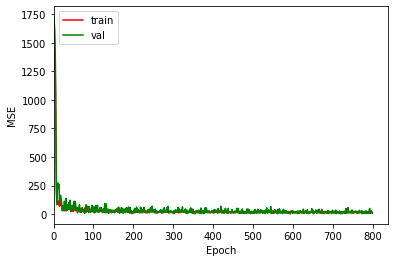

In [190]:
plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_dropoutJLA.png', dpi=100)

In [191]:
np.mean(std_mc_dropout)

3.8320475084939885

In [192]:
Om = 0.27
# variance network
w0 = -1

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [193]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

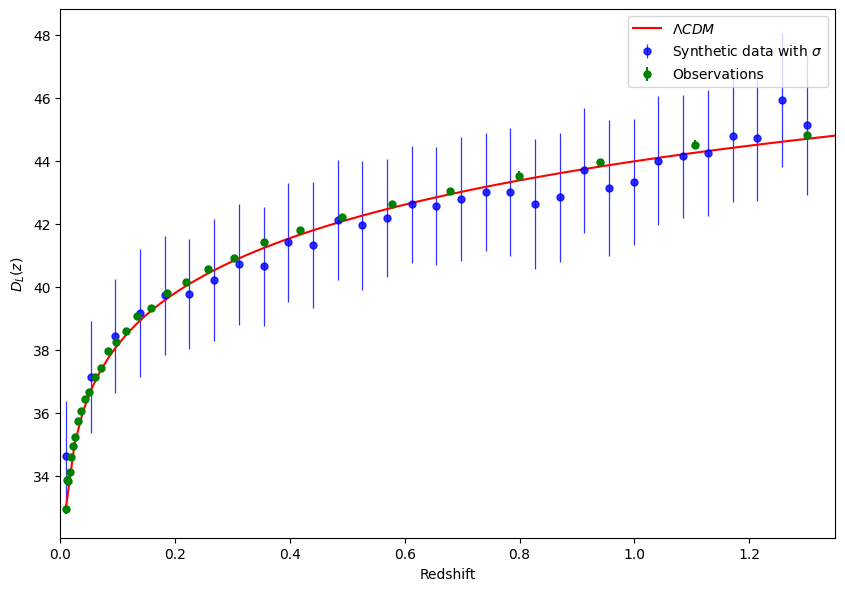

In [194]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)

fakeerrors2 = np.sqrt(np.abs(np.diagonal(prediction_mc_dropout_dec .reshape(31,31))))

# std_dropout_diag = np.sqrt(np.abs(np.diagonal(std_mc_dropout_dec.reshape(31,31))))
std_dropout_diag = np.diagonal(std_mc_dropout_dec.reshape(31,31))

# sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 + std_dropout_diag)
sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 **2 + std_dropout_diag)

plt.errorbar(ranz, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift')
plt.ylabel('$D_L(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('DL_dropout5.png', dpi=200)

In [195]:
matrix_with_all_err = prediction_mc_dropout_dec[0, :].reshape(31,31)
np.fill_diagonal(matrix_with_all_err, sigma**2)

In [196]:
np.savetxt("fake_binned_JLA_COVdecodedDO.dat", matrix_with_all_err, delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

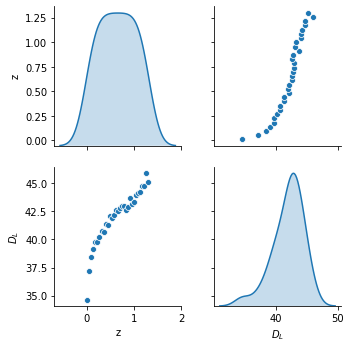

In [197]:
fake_datadf2 = pd.DataFrame(fake_data2, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf2, diag_kind="kde")
plt.savefig('fake_binned_jla22DO.png')

In [ ]:
autoencoder2.save('autoencoderJLA_DO.h5')
decoder2.save('decoderJLA_DO.h5')
neural_model2.save('FFNN_JLA_DO.h5')
encoder2.save('encoderJLA_DO.h5')